# Introduction


 - This notebook works with a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

# Objective

 - Identify customer at risk of churn

 - Highlight high-revenue products
 
 - Suggest actions to increase customer retention or cross-selling opportunities

#  Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Data Loading and Initial Exploration

In [2]:
# Load the dataset

df_raw = pd.read_csv(
    '../data/raw/Online_Retail.csv',
    encoding='latin1',
    parse_dates=["InvoiceDate"],
    date_format="%m/%d/%Y %H:%M",
    low_memory=False
)



In [3]:
# Inspect the first few rows of the dataset
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
# Convert the "InvoiceDate" column to datetime format
df_raw["InvoiceDate"] = pd.to_datetime( 
    df_raw["InvoiceDate"],
    format="%m/%d/%y %H:%M",
    errors="coerce"
)


In [5]:
# Generate a summary of the dataset
summary = {
    "rows": len(df_raw),
    "columns": df_raw.shape[1],
    "date_min": df_raw["InvoiceDate"].min(),
    "date_max": df_raw["InvoiceDate"].max(),
    "countries": df_raw["Country"].nunique(),
    "customers": df_raw["CustomerID"].nunique(),
    "products": df_raw["StockCode"].nunique(),
}

summary


{'rows': 541909,
 'columns': 8,
 'date_min': Timestamp('2010-12-01 08:26:00'),
 'date_max': Timestamp('2011-12-09 12:50:00'),
 'countries': 38,
 'customers': 4372,
 'products': 4070}

In [6]:
df_raw["Revenue"] = df_raw["Quantity"] * df_raw["UnitPrice"]

df_clean = df_raw[ # Filter out rows with non-positive quantity, unit price, or missing customer ID
    (df_raw["Quantity"] > 0) &
    (df_raw["UnitPrice"] > 0) &
    (df_raw["CustomerID"].notna())
].copy()


In [8]:
df_clean.to_csv("../data/cleaned/online_retail_clean.csv", index=False)


In [ ]:
# Calculate key transaction metrics
transactions = { 
    "invoices": df_clean["InvoiceNo"].nunique(),
    "total_revenue": df_clean["Revenue"].sum(),
    "avg_order_value": (
        df_clean.groupby("InvoiceNo")["Revenue"].sum().mean()
    ),
    "items_per_order": (
        df_clean.groupby("InvoiceNo")["Quantity"].sum().mean()
    )
}

transactions


{'invoices': 18532,
 'total_revenue': np.float64(8911407.904),
 'avg_order_value': np.float64(480.8659563997409),
 'items_per_order': np.float64(278.8588387653788)}

### Key transaction metrics:
- 18.532 Invoices
- Total revenue: $8,911,407.90
- Average order value: $480.00
- Average items per order: $278.00

# Customer Behavior Analysis

- Revenue per customer

In [ ]:
customer_metrics = ( 
    df_clean
    .groupby("CustomerID")
    .agg(
        total_revenue=("Revenue", "sum"),
        orders=("InvoiceNo", "nunique"),
        avg_order_value=("Revenue", "mean")
    )
)

customer_metrics.describe()


,total_revenue,orders,avg_order_value
count,4338.000000,4338.000000,4338.000000
mean,2054.266460,4.272015,68.350506
std,8989.230441,7.697998,1467.918896
min,3.750000,1.000000,2.101286
25%,307.415000,1.000000,12.365367
50%,674.485000,2.000000,17.723119
75%,1661.740000,5.000000,24.858417
max,280206.020000,209.000000,77183.600000


- Repeat vs one-time customers

In [ ]:
repeat_rate = (
    customer_metrics["orders"]
    .gt(1)
    .mean()
)

print(f"Repeat Purchase Rate: {repeat_rate:.2%}")


Repeat Purchase Rate: 65.58%


# RFM Analysis

- RFM stands for Recency, Frequency, and Monetary value. 
- It is a customer segmentation technique that helps businesses identify
and target their most valuable customers based on their purchasing behavior.

In [ ]:
snapshot_date = df_clean["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = (
    df_clean
    .groupby("CustomerID")
    .agg(
        Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("InvoiceNo", "nunique"),
        Monetary=("Revenue", "sum")
    )
)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


# Product Performance

- Top products by revenue

In [ ]:
# Analyze top products by revenue, quantity sold, and number of orders 
top_products = (
    df_clean
    .groupby("Description")
    .agg(
        revenue=("Revenue", "sum"),
        quantity=("Quantity", "sum"),
        orders=("InvoiceNo", "nunique")
    )
    .sort_values("revenue", ascending=False)
    .head(10)
)

top_products_by_orders = top_products.sort_values("orders", ascending=False).head(10)
top_products_by_orders


,revenue,quantity,orders
Description,,,
WHITE HANGING HEART T-LIGHT HOLDER,100448.15,36725,1971
REGENCY CAKESTAND 3 TIER,142592.95,12402,1703
JUMBO BAG RED RETROSPOT,85220.78,46181,1600
PARTY BUNTING,68844.33,15291,1379
ASSORTED COLOUR BIRD ORNAMENT,56580.34,35362,1375
POSTAGE,77803.96,3120,1099
RABBIT NIGHT LIGHT,51346.20,27202,801
Manual,53779.93,7173,253
MEDIUM CERAMIC TOP STORAGE JAR,81416.73,77916,195


- Geographic Analysis

In [ ]:
country_metrics = (
    df_clean
    .groupby("Country")
    .agg(
        revenue=("Revenue", "sum"),
        customers=("CustomerID", "nunique"),
        orders=("InvoiceNo", "nunique")
    )
    .sort_values("revenue", ascending=False)
)

country_metrics.head(10)

,revenue,customers,orders
Country,,,
United Kingdom,7308391.554,3920,16646
Netherlands,285446.340,9,94
EIRE,265545.900,3,260
Germany,228867.140,94,457
France,209024.050,87,389
Australia,138521.310,9,57
Spain,61577.110,30,90
Switzerland,56443.950,21,51
Belgium,41196.340,25,98


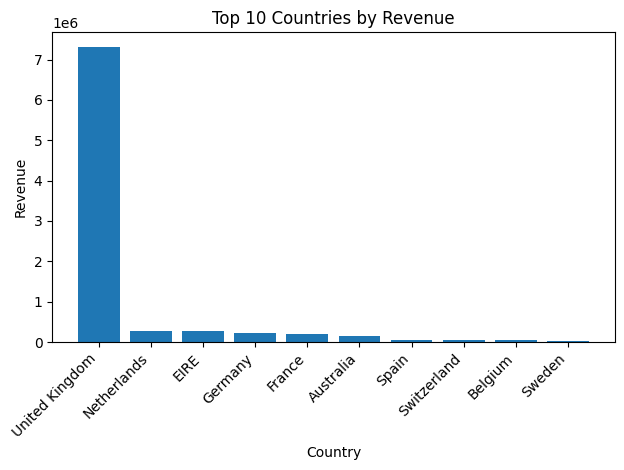

In [ ]:
country_revenue = (
    df_clean
    .groupby("Country")["Revenue"]
    .sum()
    .sort_values(ascending=False)
)

# Top 10 countries for readability
top_countries = country_revenue.head(10)

plt.figure()
plt.bar(top_countries.index, top_countries.values)
plt.xlabel("Country")
plt.ylabel("Revenue")
plt.title("Top 10 Countries by Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

UK has the market dominance, followed by Netherlands and EIRE (Ireland)

# Time Series Analysis

In [ ]:
monthly_revenue = (
    df_clean
    .set_index("InvoiceDate")
    .resample("ME")["Revenue"]
    .sum()
)

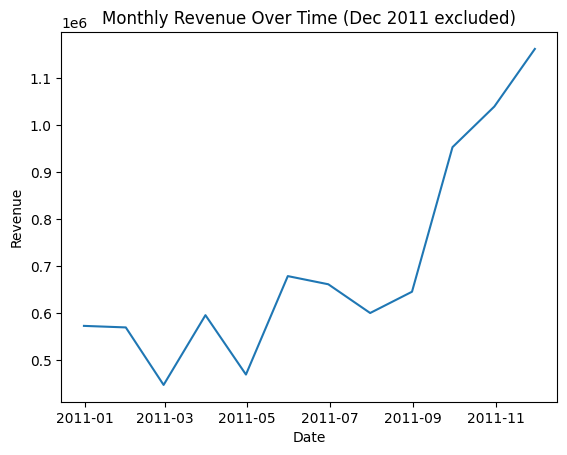

In [ ]:
# Removed Dec 2011 (incomplete month)
monthly_revenue = monthly_revenue[monthly_revenue.index < "2011-12-01"]

plt.figure()
plt.plot(monthly_revenue.index, monthly_revenue.values)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Monthly Revenue Over Time (Dec 2011 excluded)")
plt.show()

# Conclusion

This analysis explored the **Online Retail** transactional dataset to understand overall business performance, customer behavior, product dynamics, and geographic distribution.

From a data ingestion and quality perspective, the dataset required explicit handling of **character encoding** and **datetime parsing**. After cleaning returns, zero-priced items, and transactions without customer identifiers, the resulting dataset was suitable for revenue and behavioral analysis.

Key findings include:

* The business operated between **December 2010 and December 2011**, with strong revenue growth throughout 2011. December 2011 was excluded from time-series analysis due to incomplete data.
* Revenue shows clear **seasonality**, peaking toward the end of the year, which suggests holiday-driven demand.
* The customer base is relatively concentrated: a smaller group of **repeat customers** accounts for a disproportionate share of revenue.
* Product performance follows a long-tail pattern, with a limited number of items driving most sales volume.
* Geographic analysis reveals a **strong dependence on the UK market**, which dominates total revenue, while international sales contribute marginal but stable revenue streams.

Overall, the analysis highlights a business model driven by repeat purchasing behavior, seasonal demand, and market concentration. These insights provide a solid foundation for advanced analyses such as **customer segmentation (RFM)**, **retention and cohort analysis**, and **demand forecasting**, which would support data-driven decisions in marketing, inventory planning, and customer relationship management.
